In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import torch as th
import dgl

$$PV(u) = \frac{1-d}{N} + d \times \sum_{v \in \mathcal{N}(u)}
   \frac{PV(v)}{D(v)} $$

$n$是指所有节点，$D(v)$表示$v$的出度,$d$是阻尼系数.

In [46]:
N = 100;DAMP = 0.85;K = 10
g = nx.nx.erdos_renyi_graph(N,0.1)
g = dgl.DGLGraph(g)

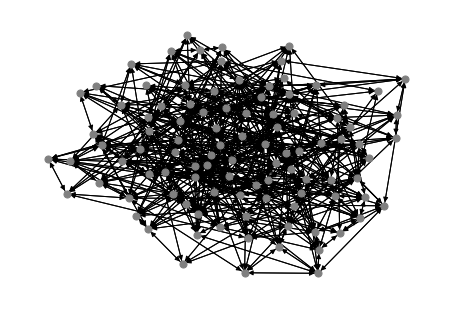

In [35]:
nx.draw(g.to_networkx(),node_size = 50,node_color=[[.5,.5,.5]])

In [47]:
g.ndata['pv'] = torch.ones(N) / N
g.ndata['deg'] = g.out_degrees(g.nodes()).float()

In [48]:
def pagerank_message_func(edges):
    '''
        edges have three members, including src,dst and data
    '''
    return {'pv' : edges.src['pv'] / edges.src['deg']}

In [49]:
def pagerank_reduce_func(nodes):
    '''
    nodes have mailbox and data
    '''
    msgs = th.sum(nodes.mailbox['pv'],dim = 1)
    pv = (1 - DAMP) / N + DAMP * msgs
    return {'pv' : pv}

In [50]:
g.register_message_func(pagerank_message_func)
g.register_reduce_func(pagerank_reduce_func)

In [51]:
def pagerank_naive(g):
    for u,v in zip(*g.edges()):
        g.send((u,v))
    for v in g.nodes():
        g.recv(v)

In [52]:
# this way more faster
def pagerank_batch(g):
    '''
    handle the node with different attribute size
    '''
    g.send(g.edges())
    g.recv(g.nodes())

In [53]:
def pagerank_level2(g):
    g.update_all()

In [58]:
import dgl.function as fn
def pagerank_buildin(g):
    '''
    more faster because using sparse matrix-vector multoplication
    '''
    g.ndata['pv'] = g.ndata['pv'] / g.ndata['deg']
    g.update_all(message_func = fn.copy_src(src = 'pv',out = 'm'),reduce_func=
                fn.sum(msg = 'm',out = 'm_sum'))
    g.ndata['pv'] = (1 - DAMP) / N + DAMP * g.ndata['m_sum']

In [59]:
from  time import time

In [62]:
start = time()
for k in range(K):
    pagerank_naive(g)
print('pagerank_navie: ',time() - start)
start = time()
for k in range(K):
    pagerank_batch(g)
print('pagerank_batch: ',time() - start)

start = time()
for k in range(K):
    pagerank_level2(g)
print('pagerank_level2: ',time() - start)

start = time()
for k in range(K):
    pagerank_buildin(g)
print('pagerank_buildin: ',time() - start)
## buildin 的方法果然快

pagerank_navie:  4.334796190261841
pagerank_batch:  0.03272294998168945
pagerank_level2:  0.0258939266204834
pagerank_buildin:  0.0043489933013916016
